Unfortunately I cannot provide the file "data.json" on which I trained the model since I do not have the permission to share it. I hope you can find my models interesting as well.

In [1]:
#import delle librerie necessarie
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler, random_split

from scipy import stats
from tqdm.notebook import tqdm
import networkx as nx
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import gc
import time
import os

import dgl
import dgl.function as fn

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
plt.style.use('ggplot')

### Exploratory analysis

The first step is exploratory analysis to better understand which dataset features are worth using. The analysis is not performed on the whole sequence but on each single grid of superconducting cables.

In [ ]:
# use pandas to read the dataset
df = pd.read_json(data_path)
df.fillna("nan",inplace=True)   # in negative sequences coordinate, time step and current are missing, so replace with the string "nan"
                                # to handle them later
# extract features and labels
x = torch.Tensor(df["sequence"]) # current grids 
y = torch.Tensor(df["label"])    # label indicating the presence of a quench in the sequence

df.head(10)

,sequence,label,quench
0,"[[20.709092344780334, 21.10844136981467, 21.84...",0,nan
1,"[[19.802651670136296, 21.62188646390244, 20.41...",0,nan
2,"[[20.093307776144727, 20.66590939967217, 21.12...",0,nan
3,"[[21.012905318373452, 19.120377913360006, 19.3...",0,nan
4,"[[22.930529765636, 19.417964108731212, 21.6034...",0,nan
5,"[[21.042166161932187, 20.747533669078138, 21.2...",0,nan
6,"[[20.970377939695716, 20.306489944849936, 19.6...",0,nan
7,"[[20.50793930335847, 21.221192507730326, 21.61...",0,nan
8,"[[22.582478486789327, 22.788005378848787, 21.8...",1,"[{'step': 18, 'pixel': [2, 1], 'temp': 25.1909..."
9,"[[22.0373877189044, 20.938335347043623, 20.948...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 25.0312..."


To understand which feature is most effective I prefer to take the single cable grids instead of entire sequences and analyze their properties.

In [ ]:
x = x.reshape((3000*24, 225)).float() # build an array containing single grids
seq_labels = torch.Tensor([]).int()   # array that will contain sequence labels

# now save the sequence label for each grid of the sequence
for label in df["label"]:
    if label == 0:
        seq_labels = torch.cat((seq_labels,torch.zeros(24)))
    else:
        seq_labels = torch.cat((seq_labels,torch.ones(24)))
seq_labels = seq_labels.int()

# create an array containing the sequence id each single grid belongs to
id = torch.Tensor([])
for i in range(0,3000):
    id = torch.cat((id, i*torch.ones(24, dtype=torch.int8)))
id = id.int()

# create an array for the time step 
single_time_sequence = torch.arange(1,25,1)
s_time = torch.Tensor([])
for i in range(3000):
    s_time = torch.cat((s_time, single_time_sequence))
s_time = s_time.int()

quench = df["quench"]
single_quench_list = { "id": [],
                       "step": []}

# now assign labels to single images instead of sequences.
# if a sequence quench entry is not "nan" it means at least one quench happened.
# when a quench occurred there is a dict containing quench timesteps, so extract them:

for (i,info) in enumerate(quench):
    if info != "nan":
        for m_info in info:
            data = pd.DataFrame(m_info)
            single_quench_list["id"].append(i)
            single_quench_list["step"].append(data["step"][0])

single_quench_label = np.zeros(3000*24)
for (idx,step) in zip(single_quench_list["id"], single_quench_list["step"]):
    index = idx * 24 + step
    single_quench_label[index] = 1 

# save the grids in a list so they can be stored in a dict   
seq_list = [tens.tolist() for tens in x] 

# compute max, min and mean current for later analysis
max_current = [max(seq) for seq in seq_list]
min_current = [min(seq) for seq in seq_list]
avg_current = [np.mean(seq) for seq in seq_list]

# create a temporary dataset to understand grid behavior
new_df_dict = {"id": id.numpy(),
               "step": s_time.numpy(),
               "single_quench_label": single_quench_label,
               "sequence": seq_list,
               "max_current": max_current,
               "min_current": min_current,
               "avg_current": avg_current,
               }

new_df = pd.DataFrame(new_df_dict)
new_df.head()

,id,step,single_quench_label,sequence,max_current,min_current,avg_current
0,0,1,0.0,"[20.70909309387207, 21.108442306518555, 21.840...",23.507584,17.965015,21.109190
1,0,2,0.0,"[20.72599220275879, 21.11109161376953, 21.8290...",23.461214,18.035686,21.110517
2,0,3,0.0,"[20.742570877075195, 21.11371421813965, 21.817...",23.415844,18.104572,21.111838
3,0,4,0.0,"[20.758834838867188, 21.116310119628906, 21.80...",23.371452,18.171724,21.113151
4,0,5,0.0,"[20.774789810180664, 21.11888313293457, 21.795...",23.328014,18.237192,21.114457


First, it's worth investigating whether time is correlated with quench occurrence. It is plausible that at early steps the material has no residual heat to dissipate, so the probability of a quench might be lower.In primis vale la pena investigare se la variabile tempo sia correlata a alla presenza di quench, è verosimile che nei primi step il materiale non contenga calore residuo da dissipare, conseguentemente la presenza di quench potrebbe essere meno probabile.

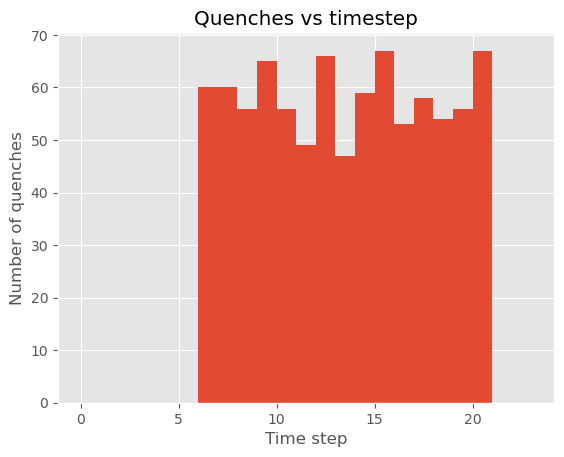

<Figure size 300x200 with 0 Axes>

In [4]:
plt_time = s_time.numpy()
plt_labels = seq_labels.numpy()
bins = np.arange(0,24,1).tolist()

plt.xlabel("Time step")
plt.ylabel("Number of quenches")
plt.title("Quenches vs timestep")
plt.hist(plt_time[new_df.single_quench_label == 1], bins)
plt.figure(figsize=(3,2))
plt.show()

Indeed quench events occur in the "central" steps.

Now evaluate current distributions and how they change depending on quench presence.
The current-related features I used are:
* maximum current
* average current
* minimum current

In [5]:
def double_plot(feature:str, x_label:str, min:float, max:float, step:float):
    bins = np.arange(min, max, step)

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,3))
    ax1.hist(new_df[feature][new_df["single_quench_label"]==0], bins=bins, range=(min, max))
    ax2.hist(new_df[feature][new_df["single_quench_label"]==1], bins=bins, range=(min, max))

    ax1.set_xlabel(x_label)
    ax1.set_ylabel("No-quench events")

    ax2.set_xlabel(x_label) 
    ax2.set_ylabel("Quench events")

    fig.suptitle(f"Quenches vs {x_label}")
    plt.show()

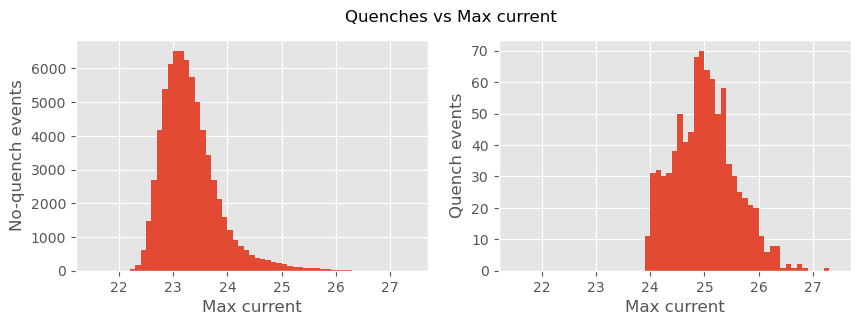

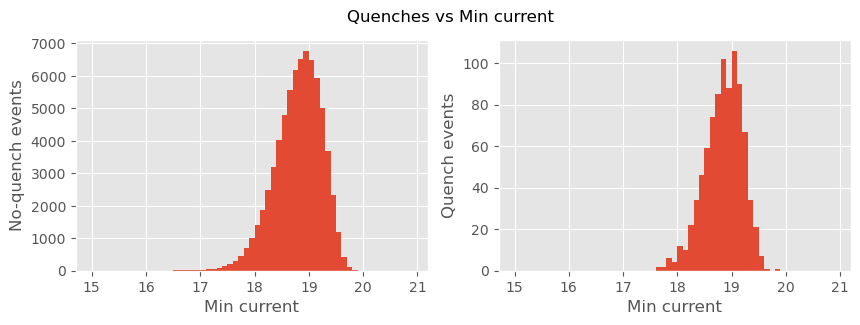

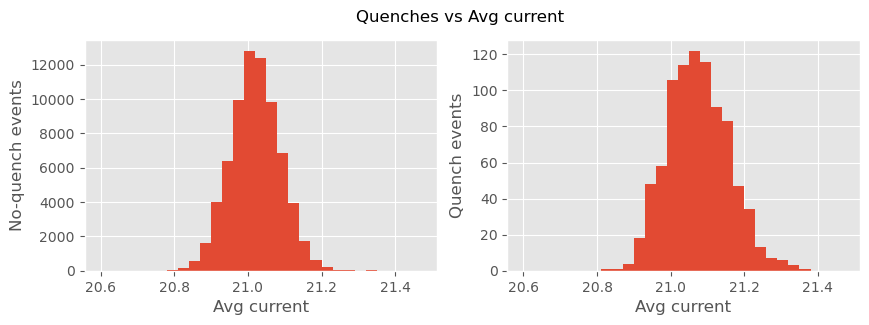

In [6]:
double_plot("max_current", "Max current", 21.5, 27.5, 0.1)
double_plot("min_current", "Min current", 15, 21, 0.1)
double_plot("avg_current", "Avg current", 20.6, 21.5, 0.03)

Observations:
* maximum current distribution is noticeably different when a quench occurs versus when it does not
* minimum current does not show substantial distribution changes
* average current distribution (with quench) is slightly shifted to the right compared to the no-quench case

### Dataset creation

Now I create the dataset. My main idea is to use a GNN as the primary model, so I build a fully connected graph dataset.
The graph contains 24 nodes, one per sequence timestep.
The choice of a GNN comes from its high expressivity and its convenience to share information among nodes for graph classification.
Each node contains 5 features:
* the grid reshaped to match (num_nodes, num_channels, width, height). Here num_nodes = 24, num_channels = 1 (no RGB), width = height = 15. This shape is used because I employ a CNN for embedding. The CNN helps learn global grid properties. From experiments, normalizing the current grid using the dataset global mean and std proved crucial for better performance.
* the timestep
* maximum current
* minimum current (even if not predictive, it didn't change model performance so it was kept)
* average current

I create the dataset to be usable for two different trainings:
* task 1: binary classification (0/1) of quench presence.
* task 2: predict the number of quenches for positive events. Because the dataset is ~90% negative, to give importance to positive events I train only on positives for this task.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, path: str):
        
        # repeat previous steps to create the dataset, this time grouped by sequence
        df = pd.read_json(path)
        df.fillna("nan",inplace=True)
        
        # save cable grids
        self.img  = torch.Tensor(df["sequence"])
        mean_curr = torch.mean(self.img.flatten(start_dim = 0))
        std_curr  = torch.std(self.img.flatten(start_dim = 0))
        self.img  = (self.img - mean_curr) / std_curr # normalize current     
        
        # save other features
        self.time = torch.arange(1,25,1).repeat(3000,1).unsqueeze(2).float()
        self.max_current, _ = torch.max(self.img, dim = 2)
        self.min_current, _ = torch.max(self.img, dim = 2)
        self.avg_current = torch.mean(self.img, dim = 2)
        
        # shape matching to standardize feature dimensions
        self.max_current = self.max_current.unsqueeze(2)
        self.min_current = self.min_current.unsqueeze(2)
        self.avg_current = self.avg_current.unsqueeze(2)
        
        # save sequence truth labels
        self.seq_label = torch.Tensor(df["label"]).unsqueeze(1)

        # save single-grid quench labels       
        quench = df["quench"]
        single_quench_list = { "id": [],
                               "step": []}

        # same loop as before to assign quench times        
        for (i,info) in enumerate(quench):
            if info != "nan": 
                for m_info in info:
                    data = pd.DataFrame(m_info)
                    single_quench_list["id"].append(i)
                    single_quench_list["step"].append(data["step"][0])
        single_quench_label = np.zeros((3000,24))
        for (idx,step) in zip(single_quench_list["id"], single_quench_list["step"]):
            single_quench_label[idx, step] = 1

        self.single_labels    = torch.Tensor(single_quench_label).unsqueeze(2)
        self.num_quenches_old = torch.sum(self.single_labels, dim = 1)
        self.num_quenches     = torch.zeros((3000, int(torch.max(self.num_quenches_old) + 1)) )

        for (i, num) in enumerate(self.num_quenches_old):
            self.num_quenches[i,int(num.item())] = 1
                           
        # create lists to iterate during training                       
        self.graphs = []
        self.labels = []

        # create nodes and connections for a fully connected graph
        nodes_dict = { "cells": 24}
        
        cell_to_cell_start = torch.arange(24).repeat(24)
        cell_to_cell_end   = torch.repeat_interleave(torch.arange(24), 24)
        
        edges_dict = {('cells','cell_to_cell','cells') : (cell_to_cell_start, cell_to_cell_end)}
        
        # graph creation loop
        for i in range (len(self.img)):
            g = dgl.heterograph(edges_dict, nodes_dict) # create the graph
            
            # assign node features  
            g.nodes["cells"].data["img"]   = self.img[i].reshape(24,1,15,15) 
            g.nodes["cells"].data["time"]  = self.time[i]
            g.nodes["cells"].data["max_current"]  = self.max_current[i]
            g.nodes["cells"].data["min_current"]  = self.min_current[i]
            g.nodes["cells"].data["avg_current"]  = self.avg_current[i]         
            self.graphs.append(g) # save graph
            self.labels.append(self.seq_label[i]) # save sequence label


        gc.collect()
        
    def __getitem__(self, index):
        # when iterating the dataset return graph, sequence label, number of quenches
        return self.graphs[index], self.labels[index], (self.num_quenches_old[index]-1).long() # -1 because multi-class categories start from 0
    
    def __len__(self):
        return len(self.graphs)

dataset = CustomDataset(data_path)

Split the dataset into train, validation and test. Training is done on the train set and performance during training is evaluated on validation. After selecting the best checkpoint by validation loss, evaluate on the test set.

In [ ]:
train_size = int(0.6 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size  = len(dataset) - train_size - valid_size

train_ds, valid_ds, test_ds = random_split(dataset, (train_size, valid_size, test_size))

batch_size = None # intentionally left batch_size = None to avoid complicating GNN cod
dl = DataLoader(dataset, batch_size = batch_size)
train_dl = DataLoader(train_ds, batch_size = batch_size)
valid_dl = DataLoader(valid_ds, batch_size = batch_size)
test_dl  = DataLoader(test_ds , batch_size = batch_size)

When building a GNN you must decide how message passing is implemented.
I tried two strategies:
* a deep-set based message passing
* an attention-based message passing

This allows comparing the two architectures. In theory these should outperform simple sum or mean aggregation.

In [ ]:
# use this simple network to embed 1D features like time, max, min, average current
def NodeEmbedding (input_size: int, ouput_size: int):
    embedding_layer = nn.Sequential(nn.Sequential(nn.Linear(1,10),
                                    nn.ReLU(inplace = True)))
    return embedding_layer

# this object defines a node update for the GNN using a deep-set style message passing
class NodeUpdate (nn.Module):
    def __init__(self, inputsize:int) -> None:
        super().__init__()
        self.phi = nn.Sequential(nn.Linear(inputsize, inputsize), 
                                 nn.ReLU(inplace=True), 
                                 nn.Linear(inputsize, inputsize))
        self.theta = nn.Sequential(nn.Linear(inputsize, inputsize), 
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(inputsize, inputsize))

    def forward(self, nodes):
        hidden  = nodes.mailbox["message"]
        inputs  = self.phi(hidden)
        outputs = self.theta(torch.sum(inputs, dim = 1))
        
        return {"message": outputs}
    
# this object implements an attention mechanism for message passing.
# this lets the network learn which nodes to focus on.

class SlotAttention (nn.Module):
    def __init__(self, num_heads: int, hidden_size: int, head_size: int) -> None:
        super().__init__()
        
        self.num_heads   = num_heads
        self.hidden_size = hidden_size
        self.head_size   = head_size
        
        # NOTE: these two networks are not actually used in the attention mechanism,
        # but removing them would require retraining and changing checkpoints.
        self.phi   = nn.Sequential(nn.Linear(hidden_size, 552), 
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(552, hidden_size))
        self.theta = nn.Sequential(nn.Linear(head_size, head_size), 
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(head_size, hidden_size))
        
        # using small MLPs improved performance compared to single linear layers
        self.key    = nn.Sequential(nn.Linear(hidden_size, hidden_size, bias=False), nn.ReLU(inplace=True), nn.Linear(hidden_size, head_size)) 
        self.query  = nn.Sequential(nn.Linear(hidden_size, hidden_size, bias=False), nn.ReLU(inplace=True), nn.Linear(hidden_size, head_size))
        self.values = nn.Sequential(nn.Linear(hidden_size, hidden_size, bias=False), nn.ReLU(inplace=True), nn.Linear(hidden_size, head_size))
        self.head_size = head_size      
        
    def edge_function(self, edges):
        attention_weights = torch.sum(edges.src['key']*edges.dst['query'],dim=1) * self.head_size ** -0.5 # compute attention scores
        attention_weights = F.softmax(attention_weights, dim = 0) 
        values = edges.src['values']
        edges.data['attention_weights'] = attention_weights 

        return {'attention' : attention_weights, 'values' : values} 
    
    def node_update(self, nodes):
        attention_weights = nodes.mailbox['attention'].unsqueeze(2)     
        weighted_sum = torch.sum(attention_weights * nodes.mailbox['values'], dim=1)
        outputs = self.theta(weighted_sum)
        
        return {"message": outputs}

    def forward(self, g):
        nodes_inputs = g.nodes["cells"].data['hidden']

        g.nodes["cells"].data['key']    = self.key(nodes_inputs)
        g.nodes["cells"].data['values'] = self.values(nodes_inputs)
        g.nodes["cells"].data['query']  = self.query(nodes_inputs)        
        g.update_all(self.edge_function, self.node_update, etype = "cell_to_cell") # update graph using attention

In [ ]:
class GNNModel(nn.Module):
    def __init__(self, mode: str, name: str) -> None:
        super().__init__()
        
        self.mode = mode # defines message passing type: deep-set, attention or simple sum
        self.name = name # model name used for saving
        
        # CNN for encoding image grids
        self.img_encoder = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(64, 256, kernel_size = 3, padding = 1),
                                         nn.ReLU(inplace = True),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.ReLU(inplace = True),
                                         nn.Flatten(1))
        
        # embed scalar node features
        self.time_encoder        = NodeEmbedding(1,10)
        self.max_current_encoder = NodeEmbedding(1,10)
        self.min_current_encoder = NodeEmbedding(1,10)
        self.avg_current_encoder = NodeEmbedding(1,10)
        
        # decoder to produce graph-level output after message passing
        self.decoder = nn.Sequential( nn.Linear(1104, 512),
                                      nn.ReLU(inplace = True),
                                      nn.Linear(512, 256),
                                      nn.ReLU(inplace = True),
                                      nn.Linear(256, 128),
                                      nn.ReLU(inplace = True),
                                      nn.Linear(128, 1),
                                      nn.Sigmoid())
        # final sigmoid to produce a probability 
        
        # attention and deep-set components
        self.head_size   = 100
        self.attention   = SlotAttention(1, 552, 100)
        self.node_update = NodeUpdate(552)

    def forward(self, g):            
        # create hidden representations for each feature
        h_img  = self.img_encoder(g.nodes["cells"].data["img"])
        h_time = self.time_encoder(g.nodes["cells"].data["time"])
        h_max  = self.max_current_encoder(g.nodes["cells"].data["max_current"])
        h_min  = self.min_current_encoder(g.nodes["cells"].data["min_current"])
        h_avg  = self.avg_current_encoder(g.nodes["cells"].data["avg_current"])
        
        # global hidden representation
        h_tot  = torch.cat((h_img, h_time, h_max, h_min, h_avg), dim = 1)
        g.nodes["cells"].data["hidden"] = h_tot        
        
        # choose message passing strategy
        if self.mode == "attention":
            self.attention(g)
        elif self.mode == "deep-set":
            for i in range(1):
                g.update_all(fn.copy_u('hidden', 'message'), self.node_update, etype= 'cell_to_cell')       
        else:
            raise TypeError("This operation mode doesn't exist")
        
        # concatenate node hidden with message and aggregate
        inputs = torch.cat((g.nodes["cells"].data["hidden"], g.nodes["cells"].data["message"]), dim = 1)
        inputs = torch.sum(inputs, dim = 0) # sum across nodes
        
        output = self.decoder(inputs) # decode to produce output probability
        
        return output

I also built a simpler DeepSet to compare a high-expressive GNN with a simpler but non-trivial model. The DeepSet uses the same encoders and decoders as the GNN; the main difference is the message passing and how aggregated information is combined.

In [ ]:
class DeepSet(nn.Module):
    def __init__(self, mode:str, name: str) -> None:
        super().__init__()
        self.name = name # defines model name
        self.mode = mode
        
        # CNN for image encoding
        self.img_encoder = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(64, 256, kernel_size = 3, padding = 1),
                                         nn.ReLU(inplace = True),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.ReLU(inplace = True),
                                         nn.Flatten(1))
        
        # embed scalar features
        self.time_encoder        = NodeEmbedding(1,10)
        self.max_current_encoder = NodeEmbedding(1,10)
        self.min_current_encoder = NodeEmbedding(1,10)
        self.avg_current_encoder = NodeEmbedding(1,10)
        
        self.decoder = nn.Sequential( nn.Linear(512 + 10 * 4, 512),
                                            nn.ReLU(inplace = True),
                                            nn.Linear(512, 256),
                                            nn.ReLU(inplace = True),
                                            nn.Linear(256, 128),
                                            nn.ReLU(inplace = True),
                                            nn.Linear(128, 1),
                                            nn.Sigmoid())
        
        
    def forward(self, g):    
        # create hidden representations for each feature
        h_img  = self.img_encoder(g.nodes["cells"].data["img"])
        h_time = self.time_encoder(g.nodes["cells"].data["time"])
        h_max  = self.max_current_encoder(g.nodes["cells"].data["max_current"])
        h_min  = self.min_current_encoder(g.nodes["cells"].data["min_current"])
        h_avg  = self.avg_current_encoder(g.nodes["cells"].data["avg_current"])
        
        # global hidden representation
        h_tot  = torch.cat((h_img, h_time, h_max, h_min, h_avg), dim = 1)
        
        output = self.decoder(torch.sum(h_tot, dim = 0)) # decode summed node features
        
        return output

Now define metric computation functions. After various attempts I settled on the following metrics:
* Accuracy — not ideal here due to class imbalance (~90% negatives), but still reported.
* True Positive Rate (TPR) — important metric for this task.
* True Negative Rate (TNR) — measures negative behavior.
* Precision — how often positive predictions are correct.

Models output the probability of a quench. We consider a quench to have occurred if p > 0.5.

In [ ]:
# structure to hold arrays used for plotting
class EvaluationMetrics:
    def __init__(self):
        self.loss_arr       = []
        self.accuracy_arr   = []
        self.tpr_arr        = []
        self.tnr_arr        = []
        self.precision_arr  = []
        self.quench_acc_arr = []
        
class MetricsValues:
    def __init__(self, size):
        # parameters updated during training
        self.acc_num = 0.0
        self.acc_den = 0.0       
        
        self.tpr_num = 0.0
        self.tpr_den = 0.0   
        
        self.tnr_num = 0.0   
        self.tnr_den = 0.0
        
        self.pre_num = 0.0
        self.pre_den = 0.0
        
        self.quench_num = 0.0
        self.quench_den = 0.0
        
        self.epoch_loss = 0.0
        self.acc        = 0.0
        self.tpr        = 0.0
        self.tnr        = 0.0
        self.pre        = 0.0 
        self.quench_acc = 0.0
        self.node_acc   = 0.0
        
        self.global_node_acc = 0.0
        self.size = 0.0 
        
    def Process(self, mode: str) -> None:
        self.mode = mode
        self.epoch_loss = self.epoch_loss / self.size # normalize loss by number of sequences
        
        if mode == "task2":
            # for task 2 we only need accuracy of predicted number of quenches
            self.quench_acc = self.quench_num / self.quench_den
        else:
            self.acc = self.acc_num / self.acc_den   

            # some denominators can be zero, so use try/except
            try:
                self.tpr = self.tpr_num / self.tpr_den
            except:
                self.tpr = -1
                
            try:
                self.pre = self.pre_num / self.pre_den
            except:
                self.pre = -1
                
            try:
                self.tnr = self.tnr_num / self.tnr_den
            except:
                self.tnr = -1
    
    def FillArr(self, metrics_arr) -> None:
        # fill arrays
        metrics_arr.loss_arr.append(self.epoch_loss)
        metrics_arr.accuracy_arr.append(self.acc)
        metrics_arr.tpr_arr.append(self.tpr)
        metrics_arr.tnr_arr.append(self.tnr)
        metrics_arr.precision_arr.append(self.pre) 
        metrics_arr.quench_acc_arr.append(self.quench_acc)
        
    def Print(self):
        # debug print
        print(self.tpr_num)
        print(self.tpr_den) 

# function to print training progress
def PrintValues(epoch, train_values, valid_values, mode) -> None:
    if mode == "task1":
        print(f"""------------------------------------------------------------------------------------------
                    Epoch: {epoch} 
                    Training loss:     {train_values.epoch_loss:.4f}  Validation loss:   {valid_values.epoch_loss:.4f} 
                    Train accuracy:    {train_values.acc:.4f}  Valid accuracy:    {valid_values.acc:.4f}
                    Train TPR:         {train_values.tpr:.4f}  Valid TPR:         {valid_values.tpr:.4f}
                    Train TNR:         {train_values.tnr:.4f}  Valid TNR:         {valid_values.tnr:.4f}
                    Train precision:   {train_values.pre:.4f}  Valid precision:   {valid_values.pre:.4f}""")
    else:
        print(f"""------------------------------------------------------------------------------------------
                    Epoch: {epoch} 
                    Training loss   :  {train_values.epoch_loss:.4f}  Validation loss :  {valid_values.epoch_loss:.4f} 
                    Train q-accuracy:  {train_values.quench_acc:.4f}  Valid q-accuracy:  {valid_values.quench_acc:.4f}""")

# compute counters used for accuracy, tpr, tnr and precision during training
def evaluate(values, g_out, graph_label):
    pred = torch.tensor([0 if y_pred < 0.5 else 1 for y_pred in g_out]).to(device) # threshold at 0.5
    pred = pred.unsqueeze(1)
    checks = torch.eq(pred, graph_label)
    acc    = torch.sum(checks)
    
    values.size += 1

    true_positive  = torch.sum(torch.logical_and(pred, graph_label)) 
    true_negative  = torch.sum(torch.logical_and(torch.logical_not(pred), torch.logical_not(graph_label))) 
    false_negative = torch.sum(torch.logical_and(torch.logical_not(pred), graph_label)) 
    false_positive = torch.sum(torch.logical_and(pred, torch.logical_not(graph_label))) 
     
    values.acc_num += acc.item()
    values.acc_den += 1
    
    values.tpr_num += true_positive.item()
    values.tpr_den += (true_positive.item() + false_negative.item())

    values.tnr_num += true_negative.item()
    values.tnr_den += (true_negative.item() + false_positive.item())

    values.pre_num += true_positive.item()
    values.pre_den += (true_positive.item() + false_positive.item())

# plotting functions for training metrics    
def PlotMetrics(n_epochs, train_metrics, valid_metrics, name, model_mode, mode = "task1",):
    epochs = list(range(n_epochs))
    
    if mode == "task1":
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,10))
        ax1.plot(epochs, train_metrics.loss_arr, label = "training")
        ax1.plot(epochs, valid_metrics.loss_arr, label = "valid")
        ax1.legend()
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("BCE loss value")

        ax2.plot(epochs, train_metrics.accuracy_arr, label = "training")
        ax2.plot(epochs, valid_metrics.accuracy_arr, label = "valid")
        ax2.legend()
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")

        ax3.plot(epochs, train_metrics.tpr_arr, label = "training")
        ax3.plot(epochs, valid_metrics.tpr_arr, label = "valid")
        ax3.legend()
        ax3.set_xlabel("Epoch")
        ax3.set_ylabel("TPR")

        ax4.plot(epochs, train_metrics.precision_arr, label = "training")
        ax4.plot(epochs, valid_metrics.precision_arr, label = "valid")
        ax4.legend()
        ax4.set_xlabel("Epoch")
        ax4.set_ylabel("Precision")

        plt.show()
        fig.savefig(f"img/{name}_{model_mode}.png")
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
        ax1.plot(epochs, train_metrics.loss_arr, label = "training")
        ax1.plot(epochs, valid_metrics.loss_arr, label = "valid")
        ax1.legend()
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Cross-entropy loss value")

        ax2.plot(epochs, train_metrics.quench_acc_arr, label = "training")
        ax2.plot(epochs, valid_metrics.quench_acc_arr, label = "valid")
        ax2.legend()
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Quench accuracy")
        fig.savefig(f"img/{name}_{model_mode}.png")

In [ ]:
# training function used for multiple models
def training_phase(model, loss_func, optimizer, epochs, train_dl, valid_dl, mode = "task1"):
    # create folder for checkpoints if it doesn't exist
    if not os.path.exists(f"{model.name}_{model.mode}"):
        os.makedirs(f"{model.name}_{model.mode}")
        
    if not os.path.exists("img"):
        os.makedirs("img")
        
    # initialize metric containers
    train_metrics = EvaluationMetrics();
    valid_metrics = EvaluationMetrics();
    
    # epoch loop
    for epoch in tqdm(range(1, epochs+1)):
        train_values = MetricsValues(train_size)
        model.train() # set model to training mode
        for g, graph_label, num_quenches  in train_dl :
            if mode != "task1":
                if graph_label == 0:
                    continue
                
            g = g.to(device) # move graph to device
            g_out = model(g) # model prediction   
                
            # compute loss depending on task
            if (mode == "task1"):
                # quench classification
                graph_label = graph_label.to(device)
                loss = loss_func(g_out, graph_label)
            else:
                # quench count inference (multiclass)
                num_quenches = num_quenches.to(device)
                loss = loss_func(g_out, num_quenches)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_values.epoch_loss += loss.detach().item()

            # evaluate metrics depending on task
            if (mode == "task1"):
                evaluate(train_values, g_out, graph_label)
            else:
                evaluate(train_values, g_out, num_quenches)

        train_values.Process(mode)
        train_values.FillArr(train_metrics)
                
        model.eval() # evaluation mode for validation
        
        # validation loop (no optimization)
        valid_values = MetricsValues(valid_size)
        for g, graph_label, num_quenches  in valid_dl:
            if mode != "task1":
                if graph_label == 0:
                    continue
                
            g = g.to(device)
            g_out = model(g)   
            
            if (mode == "task1"):
                graph_label = graph_label.to(device)
                loss = loss_func(g_out, graph_label)
            else:
                num_quenches = num_quenches.to(device)
                loss = loss_func(g_out, num_quenches) 
            
            valid_values.epoch_loss += loss.detach().item()
            
            if (mode == "task1"):
                evaluate(valid_values, g_out, graph_label)
            else:
                evaluate(valid_values, g_out, num_quenches)
            
        valid_values.Process(mode)
        valid_values.FillArr(valid_metrics)

        PrintValues(epoch, train_values, valid_values, mode)
        torch.save(model.state_dict(), f"{model.name}_{model.mode}/{model.name}_{epoch}") # save checkpoint
        
    PlotMetrics(epochs, train_metrics, valid_metrics, model.name, model.mode, mode) # plot metrics after training    

For binary classification I used Binary Cross Entropy (BCE) loss. PyTorch has BCELoss (expects probabilities) and BCEWithLogitsLoss (expects logits).
Since models use a final sigmoid, I used BCELoss.

Optimizer: AdamW. After experiments, lr = 1e-6 (written as 10e-7 in the notebook) gave smoother loss. Lower lr requires more epochs.

In [14]:
model1    = GNNModel("deep-set", "gnn").to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(model1.parameters(), lr = 10e-7)
n_epochs  = 40

#training_phase(model1, loss_func, optimizer, n_epochs, train_dl, valid_dl)

In [15]:
model2    = GNNModel("attention", "gnn").to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(model2.parameters(), lr = 10e-7)
n_epochs  = 50

#training_phase(model2, loss_func, optimizer, n_epochs, train_dl, valid_dl)

In [16]:
model3    = DeepSet("", "deep-set").to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(model3.parameters(), lr = 10e-7)
n_epochs  = 50

#training_phase(model3, loss_func, optimizer, n_epochs, train_dl, valid_dl)

#### Conclusions

To draw final conclusions I select the model checkpoint where validation loss reached its minimum and evaluate it on the test dataset.

In [ ]:
# re-declare models
gnn_attention = GNNModel("attention", "gnn")
gnn_deepset   = GNNModel("deep-set", "gnn")
deepset       = DeepSet("deep-set", "deep-set")

# load weights from chosen checkpoints
gnn_attention.load_state_dict(torch.load("weights/gnn_attention/gnn_20"))
gnn_deepset.load_state_dict(torch.load("weights/gnn_deep-set/gnn_18"))
deepset.load_state_dict(torch.load("weights/deep-set_/deep-set_35"))

# set models to evaluation mode
gnn_attention.eval()
gnn_deepset.eval()
deepset.eval()

# arrays to store true and predicted labels
test_label = []
gnn_attention_pred = []
gnn_deepset_pred   = []
deepset_pred       = [] 

# helper lists for evaluation
model_list = [gnn_attention, gnn_deepset, deepset] # preloaded models 
arr_list   = [gnn_attention_pred, gnn_deepset_pred, deepset_pred]
arr_name   = ["gnn_attention", "gnn_deepset", "deepset"]

# evaluation loop
for g, label, num_quench in test_dl:
    test_label.append(int(label.item()))
    for (i, model) in enumerate(model_list):
        out = model(g).item()
        if out < 0.5:
            arr_list[i].append(0)
        else:
            arr_list[i].append(1)       

To evaluate binary classification I create confusion matrices with true and predicted labels, and report Accuracy, TPR, TNR and Precision.

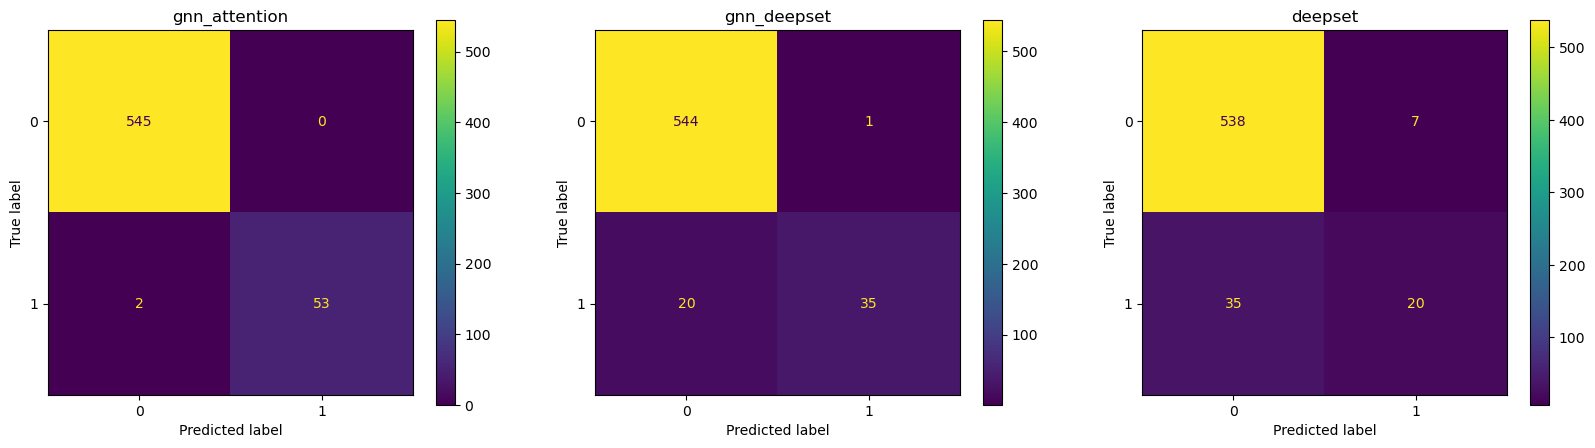

In [18]:
plt.style.use('default')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

cm1 = confusion_matrix(test_label, arr_list[0])
ConfusionMatrixDisplay(cm1).plot(ax = ax1)
ax1.set_title(arr_name[0])

cm2 = confusion_matrix(test_label, arr_list[1])
ConfusionMatrixDisplay(cm2).plot(ax = ax2)
ax2.set_title(arr_name[1])

cm3 = confusion_matrix(test_label, arr_list[2])
ConfusionMatrixDisplay(cm3).plot(ax = ax3)
ax3.set_title(arr_name[2])
plt.show()

In [ ]:
 # extract same metrics from confusion matrix
def extract_metrics(cm, title: str):
    (tn, fp, fn, tp) = cm.ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    pre = (tp) / (tp + fp)
    tpr = (tp) / (tp + fn)
    tnr = (tn) / (tn + fp)
    
    print(f"{title}: \n")
    print(f"""Accuracy : {acc:.4f} \nPrecision: {pre:.4f} \nTPR      : {tpr:.4f} \nTNR      : {tnr:.4f}\n""")

extract_metrics(cm1, arr_name[0])
extract_metrics(cm2, arr_name[1])
extract_metrics(cm3, arr_name[2])

    
    

gnn_attention: 

Accuracy : 0.9967 
Precision: 1.0000 
TPR      : 0.9636 
TNR      : 1.0000

gnn_deepset: 

Accuracy : 0.9650 
Precision: 0.9722 
TPR      : 0.6364 
TNR      : 0.9982

deepset: 

Accuracy : 0.9300 
Precision: 0.7407 
TPR      : 0.3636 
TNR      : 0.9872



In conclusion, accuracy is not a reliable metric here because of class imbalance. TPR is the key metric: GNN+attention achieves the highest TPR, confirming the expressivity of that model. GNN+deep-set performs well but worse than attention. Precision is 1 for GNN+attention in these results, meaning all predicted quenches were real. High TNR across models indicates they can detect non-quench sequences well.